# **First we extract the database we need to train the Roboflow model**

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="FhloU4T4d4KqhRFuERXh")
project = rf.workspace("panats-mp-project").project("microplastic-dataset")
version = project.version(19)
dataset = version.download("coco")

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
loading Roboflow workspace...
loading Roboflow project...


All libraries to be used are imported and updated.

In [ ]:
import torch
import torchvision
!pip install --upgrade torch torchvision
!pip install --upgrade torchtext
from torchvision.transforms.functional import pil_to_tensor
from torchvision.io import read_image, ImageReadMode
#This part is to download the pre-train Model.
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_V2_Weights, fasterrcnn_resnet50_fpn_v2

import matplotlib.pyplot as plt
from torchvision.datasets import CocoDetection
from torchvision.utils import draw_bounding_boxes
import numpy as np
from torchvision.ops import box_convert
import os
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision.transforms.functional import to_pil_image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np

In [ ]:
# Set environment variables
ANNOTATION_FILE_NAME = '_annotations.coco.json'
DATASET_NAME = 'Microplastic-Dataset-19'

# Download helpful scripts from pytorch detection
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2024-07-20 18:56:23--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.8’

     0K ...                                                   100% 94.4M=0s

2024-07-20 18:56:24 (94.4 MB/s) - ‘engine.py.8’ saved [4063/4063]

--2024-07-20 18:56:24--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

0

In [ ]:
# Uncomment to explore data
#train_data = CocoDetection(DATASET_NAME+'/train', DATASET_NAME+'/train/'+ANNOTATION_FILE_NAME)
#train_data[1]

**Define `Dataset` class constructor for our training and test data.**

In [ ]:
class Microplastic_dataset_train(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        # Root directory
        self.root = root
        # Transformations to apply on images
        self.transforms = transforms
        # Load data on COCO format
        self.data = CocoDetection(root, root+ANNOTATION_FILE_NAME)

    def __getitem__(self, idx):
        img, target = self.data[idx]
        # Convert image to tensor
        img = pil_to_tensor(img)
        # Scale tensor image
        t = torch.tensor(np.array(img) / 255).float()
        # Convert targets data to tensor
        target2 = {}
        # Labels are the same for all (1 for microplastic, 0 for background)
        target2['labels'] = torch.ones((len(target)), dtype=torch.int64)
        # The boxes data is in format 'xywh' transform to 'x_min, y_min, x_max, y_max'
        boxes = box_convert(torch.tensor([box['bbox'] for box in target],
                                        dtype=torch.int64),
                            'xywh', 'xyxy')
        target2['boxes'] = tv_tensors.BoundingBoxes(boxes, format='XYXY',
                                                    canvas_size=F.get_size(img))
        # Prepare other data
        target2['area'] = torch.tensor([box['area'] for box in target],
                                      dtype=torch.int64)
        target2['image_id']= torch.tensor([box['image_id'] for box in target],
                                         dtype=torch.int64)
        target2['iscrowd'] = torch.tensor([box['iscrowd'] for box in target],
                                         dtype=torch.int64)

        # Apply transformation
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return t, target2

    def __len__(self):
        return len(self.data)

In [ ]:
class Microplastic_dataset_valid(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        # Root directory
        self.root = root
        # Transformations to apply on images
        self.transforms = transforms
        # Load data on COCO format
        self.data = CocoDetection(root, root+ANNOTATION_FILE_NAME)

    def __getitem__(self, idx):
        img, target = self.data[idx]
        # Convert image to tensor
        img = pil_to_tensor(img)
        # Scale tensor image
        t = torch.tensor(np.array(img) / 255).float()
        # Convert targets data to tensor
        target2 = {}
        # Labels are the same for all (1 for microplastic, 0 for background)
        target2['labels'] = torch.ones((len(target)), dtype=torch.int64)
        # The boxes data is in formar 'xywh' transform to 'x_min, y_min, x_max, y_max'
        boxes = box_convert(torch.tensor([box['bbox'] for box in target],
                                        dtype=torch.int64),
                            'xywh', 'xyxy')
        target2['boxes'] = tv_tensors.BoundingBoxes(boxes, format='XYXY',
                                                    canvas_size=F.get_size(img))
        # Prepare other data
        target2['area'] = torch.tensor([box['area'] for box in target],
                                      dtype=torch.int64)
        target2['image_id']= torch.tensor([box['image_id'] for box in target],
                                         dtype=torch.int64)
        target2['iscrowd'] = torch.tensor([box['iscrowd'] for box in target],
                                         dtype=torch.int64)

        # Apply transformation
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return t, target2

    def __len__(self):
        return len(self.data)

As we will work with a pre-trained model for efficiency. First, we must load it properly

In [ ]:
# Define model
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = torchvision.models.detection.faster_rcnn(weights=weights)
# Adjust final layer to predict detect microplastic and background
num_classes = 2
# Ensure number of features from tensors
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Update model
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /home/hackathon004/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:04<00:00, 37.2MB/s] 


In [ ]:
# Define customs transformations for data
def get_transform(train):
    transforms = []
    # Train data, randomly rotae and Flip images
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomRotation((0, 180)))
    # Ensure scaled data type
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
# Define collate function
def my_collate(batch):
    '''Transform data from batch in appropiate input for the model'''
    features = []
    targets = []
    for sample in batch:
        features.append(sample[0])
        #sample[1]['boxes'] = sample[1]['boxes']
        targets.append(sample[1])
    return features, targets

In [ ]:
# Load datasets
dataset = Microplastic_dataset_train('Microplastic-Dataset-19/train/', transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn = my_collate
)

dataset_test = Microplastic_dataset_valid('Microplastic-Dataset-19/valid/', transforms=get_transform(train=False))
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=my_collate)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


The model is trained with the Microplastics dataset.

In [ ]:
from engine import train_one_epoch

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.train()

model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 15

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader, device=device)

print("That's it!")

Epoch: [0]  [  0/289]  eta: 0:00:34  lr: 0.000022  loss: 0.0804 (0.0804)  classification: 0.0071 (0.0071)  bbox_regression: 0.0733 (0.0733)  time: 0.1180  data: 0.0324  max mem: 3304
Epoch: [0]  [ 10/289]  eta: 0:00:31  lr: 0.000196  loss: 0.2916 (0.3414)  classification: 0.1085 (0.1323)  bbox_regression: 0.1980 (0.2091)  time: 0.1127  data: 0.0335  max mem: 3304
Epoch: [0]  [ 20/289]  eta: 0:00:29  lr: 0.000369  loss: 0.3436 (0.3350)  classification: 0.1239 (0.1273)  bbox_regression: 0.2267 (0.2077)  time: 0.1111  data: 0.0331  max mem: 3304
Epoch: [0]  [ 30/289]  eta: 0:00:28  lr: 0.000543  loss: 0.3563 (0.3310)  classification: 0.1296 (0.1246)  bbox_regression: 0.2302 (0.2064)  time: 0.1080  data: 0.0310  max mem: 3304
Epoch: [0]  [ 40/289]  eta: 0:00:27  lr: 0.000716  loss: 0.2795 (0.3246)  classification: 0.1031 (0.1208)  bbox_regression: 0.1787 (0.2038)  time: 0.1082  data: 0.0307  max mem: 3304
Epoch: [0]  [ 50/289]  eta: 0:00:26  lr: 0.000890  loss: 0.3022 (0.3268)  classificat

After training, the trained model can be exported for later use. If next cell is skipped the efficiency of the trained model can be tested.

In [ ]:
model.eval()
torch.save(model, 'model_scripted.pb')

This cell can be used to load an already trained model for further evaluation. The commented part is used in case of not having a GPU.


In [ ]:
model = torch.load('model_scripted_retinanet_resnet50_fpn.pb') #, map_location=torch.device('cpu'))

Define evaluation functions

In [ ]:
def get_predictions(model, data_loader, device):
    # Set mode in evaluation mode
    model.eval()
    all_predictions = []
    with torch.no_grad():
        # Iterate over test data
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            # Prepare predictions
            for target, output in zip(targets, outputs):
                pred = {'boxes': output['boxes'].cpu(),
                        'labels': output['labels'].cpu().numpy(),
                        'scores': output['scores'].cpu().numpy(),
                        'image_id': np.zeros_like(output['labels'].cpu().numpy()) + target['image_id'][0].item()}
                all_predictions.append(pred)
    return all_predictions

In [ ]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

In [ ]:
def prepare_for_coco_detection(predictions):
    '''Transform prediction from model into COCO valid format'''
    coco_results = []
    if len(predictions) == 0:
        return None
    for prediction in predictions:
        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": prediction['image_id'][k],
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [ ]:
def coco_evaluation(model, data_loader, annotation_file, device):
    '''Evaluate model on COCO dataset'''
    model_predictions = get_predictions(model, data_loader, device)
    results = prepare_for_coco_detection(model_predictions)

    coco_gt = COCO(annotation_file)
    coco_dt = coco_gt.loadRes(results)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval.stats

This cell is for evaluation. It prints different statistics of Average Recall and Average Precision.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

path = 'Microplastic-Dataset-19/valid/' + ANNOTATION_FILE_NAME
coco_stats = coco_evaluation(model, data_loader_test, path, device)
print("COCO Evaluation Metrics:")
print(f"Average Precision (AP) @[IoU=0.50:0.95]: {coco_stats[0]:.4f}")
print(f"Average Precision (AP) @[IoU=0.50]: {coco_stats[1]:.4f}")
print(f"Average Precision (AP) @[IoU=0.75]: {coco_stats[2]:.4f}")
print(f"Average Recall (AR) @[IoU=0.50:0.95]: {coco_stats[8]:.4f}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.31260
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.69275
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.23169
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.13990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.43175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.70149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.06949
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.35373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

From here the trained model is fed a random image from the data set and printed to see what the prediction looks like.

In [ ]:
eval_transform = get_transform(train=False)
image = read_image('Microplastic-Dataset-19/valid/b--12-_jpg.rf.016f209b7c5439a4f12cfde8e1b20114.jpg')

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"MP: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()

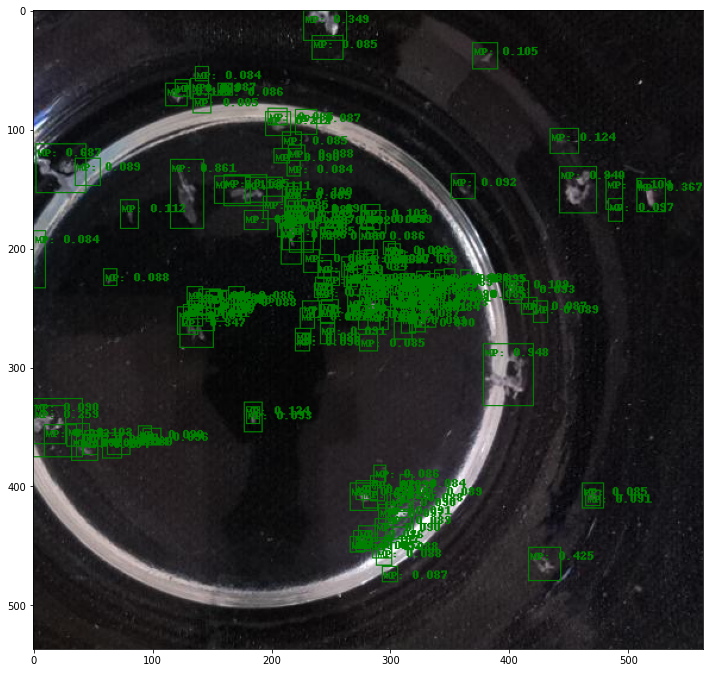

In [ ]:
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="green")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
from sklearn.metrics import confusion_matrix

# Get predictions
all_predictions = []
true_labels = []
for images, targets in data_loader_test:
    images = list(img.to(device) for img in images)
    outputs = model(images)
    for target, output in zip(targets, outputs):
        all_predictions.extend(output['labels'].cpu().numpy())
        true_labels.extend(target['labels'].cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, all_predictions)

# Display confusion matrix
print(cm)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()